In [ ]:
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook
import pandas as pd
import utils

In [ ]:
normal_df = pd.read_csv('processed_data/adjusted_consumption_sample.csv')

In [ ]:
fraud_df = pd.read_csv("processed_data/data_fraud_meter.csv")

In [ ]:
fraud_df= utils.large_change_handling(fraud_df)

In [ ]:
fraud_df = utils.normalize_data_frequency(fraud_df)

In [ ]:
normal_df.NGAYGIO = pd.to_datetime(normal_df.NGAYGIO)

In [ ]:
normal_df = utils.normalize_data_frequency(normal_df)

In [ ]:
normal_df['IS_FRAUD'] = False
fraud_df['IS_FRAUD'] = True

# Tuning Daily Threshold

* **Volatility Threshold**
* **Num violations threshold**

In [ ]:
summary_df = pd.concat([normal_df, fraud_df])

In [ ]:
summary_df['IMPORT_KWH_SHIFT1'] = summary_df.groupby("MA_DIEMDO").MILESTONE_IMPORT_KWH.shift(1)
summary_df['CONSUMPTION'] = summary_df.MILESTONE_IMPORT_KWH - summary_df.IMPORT_KWH_SHIFT1
summary_df['DATE'] = summary_df.index.floor("D")

In [ ]:
aggregated_df = summary_df.groupby(["MA_DIEMDO",'DATE','IS_FRAUD']).CONSUMPTION.sum().reset_index()

In [ ]:
mean_consumption = aggregated_df.groupby("MA_DIEMDO").CONSUMPTION.mean().reset_index().rename({"CONSUMPTION":"MEAN_CONSUMPTION"},axis=1)

In [ ]:
aggregated_df = pd.merge(aggregated_df, mean_consumption, on='MA_DIEMDO')

In [ ]:
aggregated_df['PCT_CHANGE'] = (aggregated_df.CONSUMPTION - aggregated_df.MEAN_CONSUMPTION)/aggregated_df.MEAN_CONSUMPTION

In [57]:
def gen_tuning_stat(aggregated_df):
    results1 = []
    results2 = []
    for i in tqdm_notebook(range(1,10),total=9):
        volatility_threshold = aggregated_df.PCT_CHANGE.quantile(0.1*i)
#         print("OPTIMIZING VOLATILITY THRESHOLD:",volatility_threshold)
        if volatility_threshold < 0:
            aggregated_df['IS_OUTLIER'] = aggregated_df.PCT_CHANGE < volatility_threshold
        else:
            aggregated_df['IS_OUTLIER'] = aggregated_df.PCT_CHANGE > volatility_threshold
        aggregated_df['NUM_OUTLIERS'] = aggregated_df.groupby('MA_DIEMDO').IS_OUTLIER.rolling(7).sum().reset_index(0,drop=True)
#         print("OPTIMIZING NUM OUTLIERS THRESHOLD...")
        for j in tqdm_notebook(range(1,10),total=9):
            num_outliers_threshold = aggregated_df.NUM_OUTLIERS.quantile(0.1*j)
            aggregated_df['IS_OUTLIER_2'] = aggregated_df.NUM_OUTLIERS > num_outliers_threshold
            aggregated_df['AGG_OUTLIER'] = aggregated_df.IS_OUTLIER_2 & aggregated_df.IS_OUTLIER
            stats = aggregated_df.groupby(['IS_FRAUD','MA_DIEMDO']).AGG_OUTLIER.mean().reset_index()
            stats['VOL_THRESHOLD'] = volatility_threshold
            stats['VOL_PERCENTILE'] = i
            stats['NUM_THRESHOLD'] = num_outliers_threshold
            stats['NUM_PERCENTILE'] = j
            results1.append(stats)
            stats = aggregated_df.groupby(['IS_FRAUD']).AGG_OUTLIER.mean().reset_index()
            stats['VOL_THRESHOLD'] = volatility_threshold
            stats['VOL_PERCENTILE'] = i
            stats['NUM_THRESHOLD'] = num_outliers_threshold
            stats['NUM_PERCENTILE'] = j
            results2.append(stats)

    stat = pd.concat(results2)

    stat.drop_duplicates(subset=['IS_FRAUD','VOL_THRESHOLD','NUM_THRESHOLD'],inplace=True)
    stat=stat.pivot_table(index=['VOL_THRESHOLD','VOL_PERCENTILE','NUM_THRESHOLD','NUM_PERCENTILE'],columns=['IS_FRAUD'],values = ['AGG_OUTLIER']).reset_index()
    stat['DIFF']= stat[(   'AGG_OUTLIER', True)] - stat[(   'AGG_OUTLIER', False)]
    stat.sort_values(by='DIFF',ascending=False, inplace=True)
    return stat

In [58]:
stat = gen_tuning_stat(aggregated_df)

In [54]:
 .head()

VOL_THRESHOLD VOL_PERCENTILE NUM_THRESHOLD NUM_PERCENTILE  \
IS_FRAUD                                                             
39            0.254729              8           0.0              1   
0            -0.497412              1           0.0              1   
33            0.135538              7           0.0              1   
3            -0.313018              2           1.0              7   
40            0.254729              8           1.0              7   

         AGG_OUTLIER                DIFF  
IS_FRAUD       False      True            
39          0.196505  0.240944  0.044439  
0           0.094187  0.138435  0.044248  
33          0.296244  0.338334  0.042090  
3           0.173613  0.215168  0.041555  
40          0.177535  0.217817  0.040282

VOL_THRESHOLD VOL_PERCENTILE NUM_THRESHOLD NUM_PERCENTILE  \
IS_FRAUD                                                             
23           -0.035825              5           5.0              6   
24           -0.035825              5           6.0              7   
19           -0.035825              5           0.0              1   
20           -0.035825              5           1.0              3   
22           -0.035825              5           3.0              5   
21           -0.035825              5           2.0              4   
17           -0.117162              4           6.0              8   
16           -0.117162              4           5.0              7   
38            0.135538              7           7.0              9   
32            0.042455              6           7.0              9   
18           -0.117162              4           7.0              9   
11           -0.204604              3           7.0              9   
25           -0.035825              5           7.0              8   
12           -0.117162              4           0.0              1   
13           -0.117162              4           1.0              4   
14           -0.117162              4           2.0              5   
15           -0.117162              4           3.0              6   
5            -0.313018              2           6.0              9   
10           -0.204604              3           5.0              8   
6            -0.204604              3           0.0              1   
7            -0.204604              3           1.0              5   
9            -0.204604              3           3.0              7   
1            -0.497412              1           3.0              9   
8            -0.204604              3           2.0              6   
30            0.042455              6           5.0              7   
29            0.042455              6           3.0              6   
28            0.042455              6           2.0              5   
45            0.479180              9           3.0              9   
27            0.042455              6           1.0              4   
42            0.254729              8           6.0              9   
31            0.042455              6           6.0              8   
36            0.135538              7           3.0              7   
26            0.042455              6           0.0              1   
37            0.135538              7           5.0              8   
4            -0.313018              2           3.0              8   
35            0.135538              7           2.0              6   
41            0.254729              8           3.0              8   
44            0.479180              9           1.0              8   
34            0.135538              7           1.0              5   
2            -0.313018              2           0.0              1   
43            0.479180              9           0.0              1   
40            0.254729              8           1.0              7   
3            -0.313018              2           1.0              7   
33            0.135538              7           0.0              1   
0            -0.497412              1           0.0              1   
39            0.254729              8           0.0              1   

         AGG_OUTLIER                DIFF  
IS_FRAUD       False      True            
23          0.342321  0.315862 -0.026460  
24          0.268497  0.242164 -0.026333  
19          0.492551  0.468762 -0.023789  
20          0.475584  0.452511 -0.023074  
22          0.425602  0.402863 -0.022739  
21          0.453490  0.431467 -0.022023  
17          0.191655  0.186773 -0.004883  
16          0.248780  0.247046 -0.001734  
38          0.000000  0.000000  0.000000  
32          0.000000  0.000000  0.000000  
18          0.000000  0.000000  0.000000  
11          0.000000  0.000000  0.000000  
25          0.000000  0.000000  0.000000  
12 

In [49]:
temp = aggregated_df.groupby("MA_DIEMDO").IS_OUTLIER.rolling(7).sum()

In [56]:
aggregated_df.groupby('MA_DIEMDO').IS_OUTLIER.rolling(7).sum()

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
569705    0.0
569706    0.0
569707    0.0
569708    0.0
569709    0.0
Name: IS_OUTLIER, Length: 569710, dtype: float64

In [57]:
aggregated_df['NUM_OUTLIERS'] = aggregated_df.groupby('MA_DIEMDO').IS_OUTLIER.rolling(7).sum().reset_index(0,drop=True)


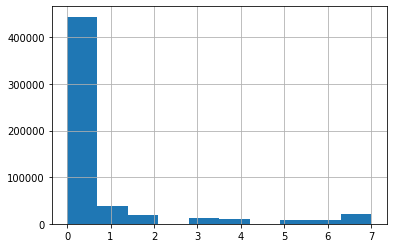

In [59]:
aggregated_df.NUM_OUTLIERS.hist()

In [53]:
aggregated_df.groupby('MA_DIEMDO').IS_OUTLIER.shift(1)

0           NaN
1         False
2         False
3         False
4         False
          ...  
569705    False
569706    False
569707    False
569708    False
569709    False
Name: IS_OUTLIER, Length: 569710, dtype: object

In [41]:
results = []
for i in range(1,10):
    volatility_threshold = aggregated_df.PCT_CHANGE.quantile(0.1*i)
    print("-"*80)
    print("OPTIMIZING VOLATILITY THRESHOLD:",volatility_threshold)
    if volatility_threshold < 0:
        aggregated_df['IS_OUTLIER'] = aggregated_df.PCT_CHANGE < volatility_threshold
    else:
        aggregated_df['IS_OUTLIER'] = aggregated_df.PCT_CHANGE > volatility_threshold

    consecutive_outlier_df = weekly_df.groupby(["MA_DIEMDO",'IS_FRAUD']).agg({"is_outlier":utils.max_num_consecutive_outliers}).reset_index()
    print("OPTIMIZING CONSECUTIVE THRESHOLD...")
    consecutive_outlier_df['NUM_CONSECUTIVE'] = consecutive_outlier_df.is_outlier.str[0]
    for j in tqdm_notebook(range(1,10),total=9):
        consecutive_threshold = consecutive_outlier_df.NUM_CONSECUTIVE.quantile(0.1*j)
        consecutive_outlier_df['IS_OUTLIER'] = consecutive_outlier_df.NUM_CONSECUTIVE > consecutive_threshold
        stats = consecutive_outlier_df.groupby("IS_FRAUD").IS_OUTLIER.mean().reset_index()
        stats['VOL_THRESHOLD'] = volatility_threshold
        stats['VOL_PERCENTILE'] = i
        stats['CON_THRESHOLD'] = consecutive_threshold
        stats['CON_PERCENTILE'] = j
        results.append(stats)
    
    

,MA_DIEMDO,DATE,IS_FRAUD,CONSUMPTION,MEAN_CONSUMPTION,CHANGE_PCT
0,PP01000100340001,2017-01-01,False,2.639168,3.798207,-0.305154
1,PP01000100340001,2017-01-02,False,4.366592,3.798207,0.149646
2,PP01000100340001,2017-01-03,False,3.439982,3.798207,-0.094314
3,PP01000100340001,2017-01-04,False,2.693481,3.798207,-0.290855
4,PP01000100340001,2017-01-05,False,2.528870,3.798207,-0.334194


In [ ]:
weekly_normal_df = utils.weekly_comsumption(normal_df)
weekly_fraud_df = utils.weekly_comsumption(fraud_df)

In [ ]:
weekly_fraud_df['IS_FRAUD'] = True
weekly_normal_df['IS_FRAUD'] = False

In [ ]:
weekly_df = pd.concat([weekly_fraud_df,weekly_normal_df])

## Rule 1: compare to Last Week consumption

In [ ]:
weekly_fraud_df.head()

In [ ]:
mean_weekly_consumption = weekly_df.groupby("MA_DIEMDO").CONSUMPTION.mean().reset_index().rename({"CONSUMPTION":"MEAN_CONSUMPTION"},axis=1)


In [ ]:
weekly_df = pd.merge(weekly_df, mean_weekly_consumption, on='MA_DIEMDO')

In [ ]:
weekly_df.head()

In [ ]:
weekly_normal_df.head()

In [ ]:
weekly_df.dropna(subset=['CONSP_LAST_WEEK'],inplace=True)

In [ ]:
weekly_df['PCT_CHANGE'] = (weekly_df.CONSUMPTION - weekly_df.MEAN_CONSUMPTION)/weekly_df.MEAN_CONSUMPTION

In [ ]:
result = pd.concat(results).drop_duplicates(subset=['VOL_THRESHOLD','CON_THRESHOLD','IS_FRAUD'])

In [ ]:
result.pivot_table(index=['VOL_THRESHOLD','VOL_PERCENTILE','CON_THRESHOLD','CON_PERCENTILE'],columns=['IS_FRAUD'],values = ['IS_OUTLIER'])

In [ ]:
    if volatility_threshold < 0:
        weekly_df['is_outlier'] = weekly_df.PCT_CHANGE < volatility_threshold
    else:
        weekly_df['is_outlier'] = weekly_df.PCT_CHANGE > volatility_threshold

    consecutive_outlier_df = weekly_df.groupby(["MA_DIEMDO",'IS_FRAUD']).agg({"is_outlier":utils.max_num_consecutive_outliers}).reset_index()
    consecutive_outlier_df['NUM_CONSECUTIVE']consecutive_outlier_df.is_outlier.str[0]

In [ ]:
weekly_df[weekly_df.IS_FRAUD].PCT_CHANGE.hist()

In [ ]:
weekly_df[~weekly_df.IS_FRAUD & (weekly_df.PCT_CHANGE<0)].PCT_CHANGE.hist()

In [ ]:
.